In [1]:
%%capture
! pip install -q git+https://github.com/EfficientDL/codelab_utils.git
! pip install tensorflow-model-optimization

import pickle

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [2]:
%%capture
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'oxford_flowers102',
    with_info=True,
    split=['train', 'validation', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

2022-08-10 12:51:59.532491: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-08-10 12:52:31.241448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 12:52:31.338706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 12:52:31.339470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

In [3]:
# Dataset image size
IMG_SIZE = 264

def preprocess(item):
    image, label = item['image'], item['label']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    return image, label

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

## Make Triplets

In [4]:
N_CLASSES = 102
SHUFFLE_BUFFER_SIZE = 500

def make_triplets(ds):
    all_triplets = None

    def pick_image(image, label): return image
    # def pick_image(image, label): return (image, label)

    for idx in range(N_CLASSES):
        anchor_ds = ds.filter(lambda _,y: y == idx).map(pick_image)
        positive_ds = anchor_ds.shuffle(SHUFFLE_BUFFER_SIZE)
        negative_ds = ds.filter(lambda _,y: y != idx).map(pick_image)
        triplet_ds = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))
        triplet_ds = triplet_ds.map(lambda x,y,z: tf.stack([x, y, z], axis=0))
        triplet_ds = tf.data.Dataset.zip((triplet_ds, ds.map(lambda x,y: 0)))

        all_triplets = triplet_ds if not all_triplets else all_triplets.concatenate(triplet_ds)
    
    return all_triplets
    
train_triplet_ds = make_triplets(
    train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True)
)

2022-08-10 12:52:54.327461: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


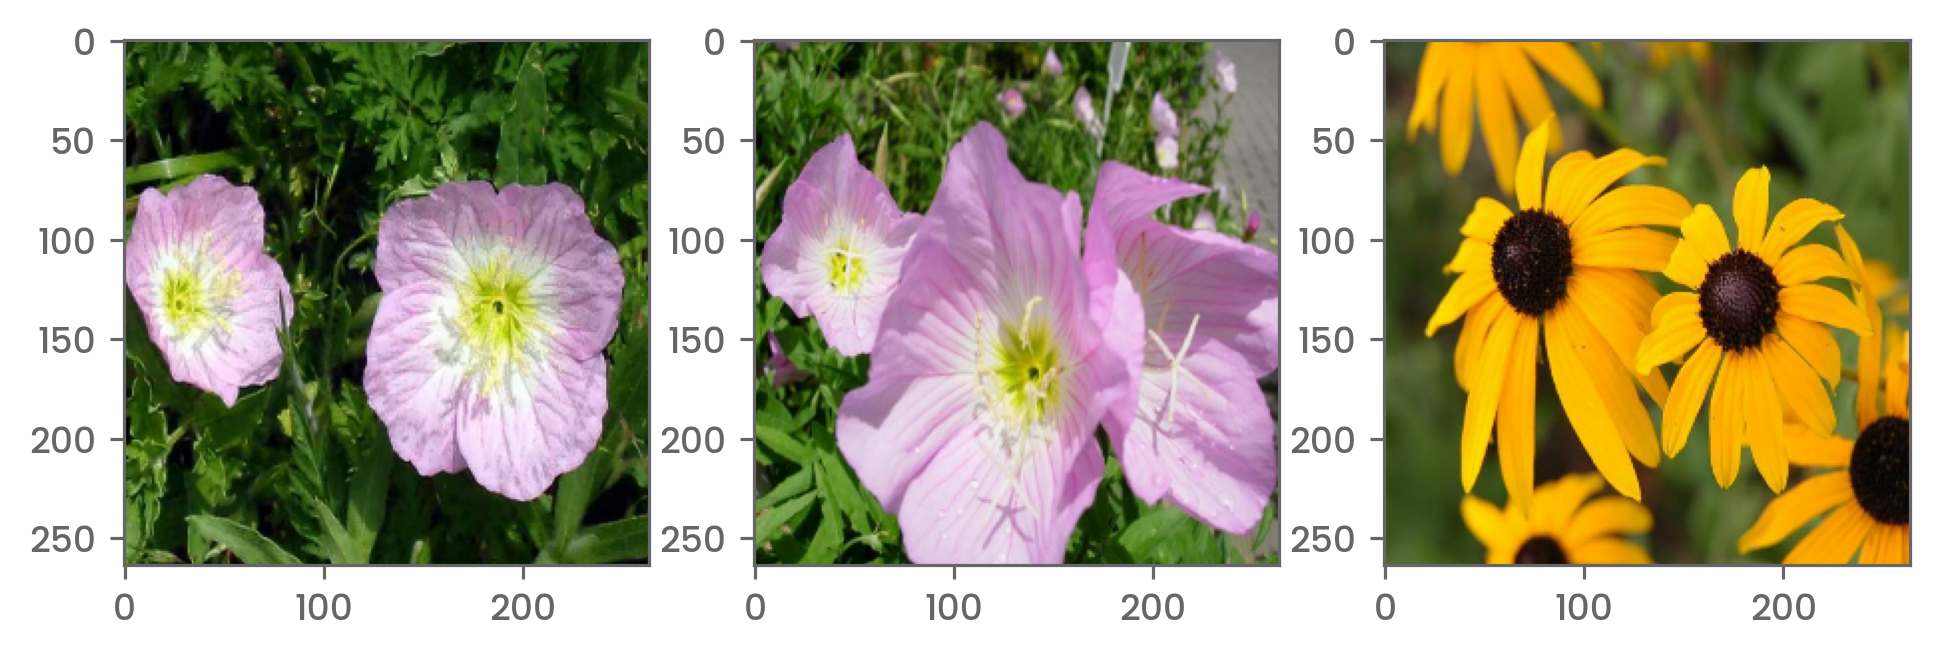

In [5]:
itr = train_triplet_ds.shuffle(10).as_numpy_iterator()
(anchor, positive, negative), label = next(itr)

def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(display_list[index]))

display([anchor, positive, negative], cols=3)

In [6]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002
DELTA = 0.5

def triplet_loss(_, features):
    anchor, positive, negative = tf.unstack(features, axis=1)
    batch_size = tf.shape(anchor)[0]

    # Compute the distances of anchor from the positive and the negative samples
    positive_dist = tf.norm(anchor-positive, axis=-1)
    negative_dist = tf.norm(anchor-negative, axis=-1)

    loss = tf.maximum(0., positive_dist-negative_dist+tf.repeat(DELTA, repeats=batch_size, axis=0))

    return loss

def create_contrastive_learning_model():
    # Initalize the core model
    core_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    core = apps.resnet50.ResNet50(**core_args)
    # core.trainable = False

    # Setup the top
    features = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
#             layers.Lambda(lambda x: tf.cast(x, tf.float32)),
            layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
            core,
            layers.Flatten(),
        ],
        name='features'
    )

    # Triplet Inputs
    triplet = layers.Input([3, IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
    anchor, positive, negative = tf.unstack(triplet, axis=1)
    output = tf.stack([features(anchor), features(positive), features(negative)], axis=1)

    model = tf.keras.Model(inputs=[triplet], outputs=output)
    adam = optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=adam, loss=triplet_loss)
    return model

cl_model = create_contrastive_learning_model()
cl_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 264, 264, 0                                            
__________________________________________________________________________________________________
tf.unstack (TFOpLambda)         [(None, 264, 264, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
features (Sequential)           (None, 165888)       23587712    tf.unstack[0][0]                 
                                                                 tf.unstack[0][1]                 
                                                                 tf.unstack[0][2]                 
_____________________________

## Contrastive Learning

In [7]:
def plot_loss(h):
    fig = plt.figure()
    ax = fig.gca()

    ax.plot(h['loss'], label='Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Losses')

    ax.legend()

--2022-08-10 12:53:07--  https://www.dropbox.com/s/v20p89309byvz48/contrastive_learning_aug_model.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/v20p89309byvz48/contrastive_learning_aug_model.h5 [following]
--2022-08-10 12:53:08--  https://www.dropbox.com/s/dl/v20p89309byvz48/contrastive_learning_aug_model.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4cdecd6f424645e4f67d0d6142.dl.dropboxusercontent.com/cd/0/get/BqsQmiScRD0LGzMfBEI9yMiD64TKQaqm0K5L5yF7SOnKx259WaIyovUN3km0KLYLtrWKkYiSyIFMlwMlkqBAybk089yY_4tcaDrmoYdyTXvuZArbWHG-Z3pHRkV9abV5449eb2wmXuaYbOSUYTHjLrNtcAb0NsaC0MVPZt-iLiTgsw/file?dl=1# [following]
--2022-08-10 12:53:08--  https://uc4cdecd6f424645e4f67d0d6142.dl.dropboxusercontent.com/cd/0/get/Bqs

2022-08-10 12:54:16.433193: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 619s 14s/step - loss: 0.4309
Epoch 2/10
43/43 [==============================] - 597s 14s/step - loss: 1.2196
Epoch 3/10
43/43 [==============================] - 596s 14s/step - loss: 0.5035
Epoch 4/10
43/43 [==============================] - 593s 14s/step - loss: 0.1361
Epoch 5/10
43/43 [==============================] - 595s 14s/step - loss: 0.1291
Epoch 6/10
43/43 [==============================] - 599s 14s/step - loss: 0.2441
Epoch 7/10
43/43 [==============================] - 598s 14s/step - loss: 0.2661
Epoch 8/10
43/43 [==============================] - 593s 14s/step - loss: 0.7862
Epoch 9/10
43/43 [==============================] - 597s 14s/step - loss: 0.3923
Epoch 10/10
43/43 [==============================] - 596s 14s/step - loss: 1.8026
{'loss': [0.43086910247802734, 1.2195582389831543, 0.5034735202789307, 0.13611626625061035, 0.12908513844013214, 0.24405179917812347, 0.26614877581596375, 0.7861628532409668, 0.3922932744026184, 1.802

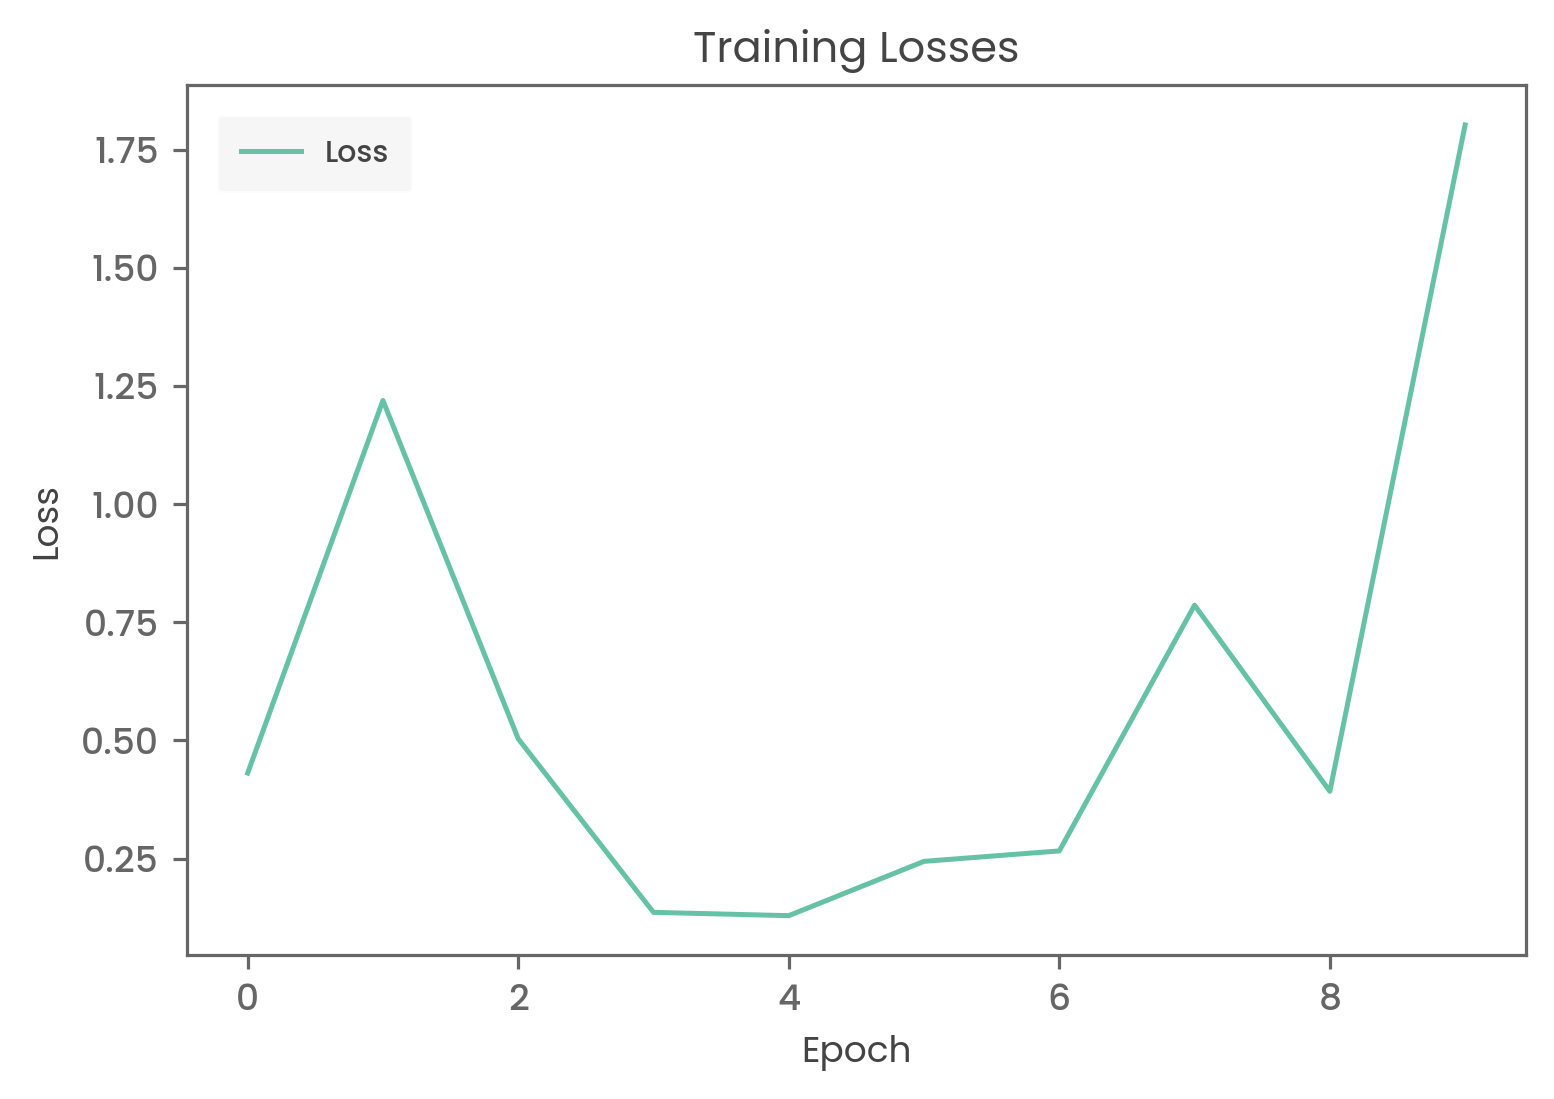

In [8]:
BATCH_SIZE = 24
# EPOCHS = 20
EPOCHS = 10
CONTRASTIVE_LEARNING_MODEL = 'contrastive_learning_model.h5'

if not Path(CONTRASTIVE_LEARNING_MODEL).exists():
#     ! wget "https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL
    ! wget "https://www.dropbox.com/s/v20p89309byvz48/contrastive_learning_aug_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL

    print('Loading the pre-trained contrastive learning model...')
    cl_model.load_weights(CONTRASTIVE_LEARNING_MODEL)

print('Training the contrastive learning model')
hist = cl_model.fit(train_triplet_ds.batch(BATCH_SIZE), epochs=EPOCHS)
plot_loss(hist.history), print(hist.history)

print('Saving the constrastive learning model as:', CONTRASTIVE_LEARNING_MODEL)
cl_model.save_weights(CONTRASTIVE_LEARNING_MODEL)

## Classifier

In [9]:
def create_classification_model(core):
#     core.trainable = False

    inp = layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
    head = tf.keras.Sequential([
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(N_CLASSES, activation='softmax')
        ],
        name='classification_head')

    features = core(inp)
    output = head(features)

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss='sparse_categorical_crossentropy'
    metrics=['accuracy']

    model = tf.keras.Model(inputs=[inp], outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

classifier = create_classification_model(cl_model.layers[2])
classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 264, 264, 3)]     0         
_________________________________________________________________
features (Sequential)        (None, 165888)            23587712  
_________________________________________________________________
classification_head (Sequent (None, 102)               16920678  
Total params: 40,508,390
Trainable params: 40,455,270
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
BATCH_SIZE = 24
EPOCHS = 100
CLASSIFIER_MODEL = 'classifier_model.h5'

# tds = train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).take(1)
# vds = val_prep_ds.batch(256).cache().take(1)
tds = train_prep_ds.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

# Save the best weights during training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

hist = classifier.fit(tds, validation_data=vds, epochs=EPOCHS, callbacks=[early_stopping])
print(hist.history)

print('Saving the classifier model as:', CLASSIFIER_MODEL)
classifier.save_weights(CLASSIFIER_MODEL)
classifier.evaluate(test_prep_ds.batch(256))

Epoch 1/100
43/43 [==============================] - 23s 403ms/step - loss: 4.4760 - accuracy: 0.1333 - val_loss: 4.1151 - val_accuracy: 0.2314
Epoch 2/100
43/43 [==============================] - 14s 295ms/step - loss: 1.4346 - accuracy: 0.6245 - val_loss: 3.7818 - val_accuracy: 0.3294
Epoch 3/100
43/43 [==============================] - 14s 297ms/step - loss: 0.6208 - accuracy: 0.8294 - val_loss: 2.9314 - val_accuracy: 0.4559
Epoch 4/100
43/43 [==============================] - 14s 295ms/step - loss: 0.4337 - accuracy: 0.8784 - val_loss: 2.4478 - val_accuracy: 0.5304
Epoch 5/100
43/43 [==============================] - 14s 294ms/step - loss: 0.2576 - accuracy: 0.9176 - val_loss: 2.8212 - val_accuracy: 0.4951
Epoch 6/100
43/43 [==============================] - 13s 292ms/step - loss: 0.2042 - accuracy: 0.9373 - val_loss: 3.1982 - val_accuracy: 0.4784
Epoch 7/100
43/43 [==============================] - 14s 297ms/step - loss: 0.1501 - accuracy: 0.9529 - val_loss: 3.5315 - val_accuracy:

[3.005645990371704, 0.49715399742126465]

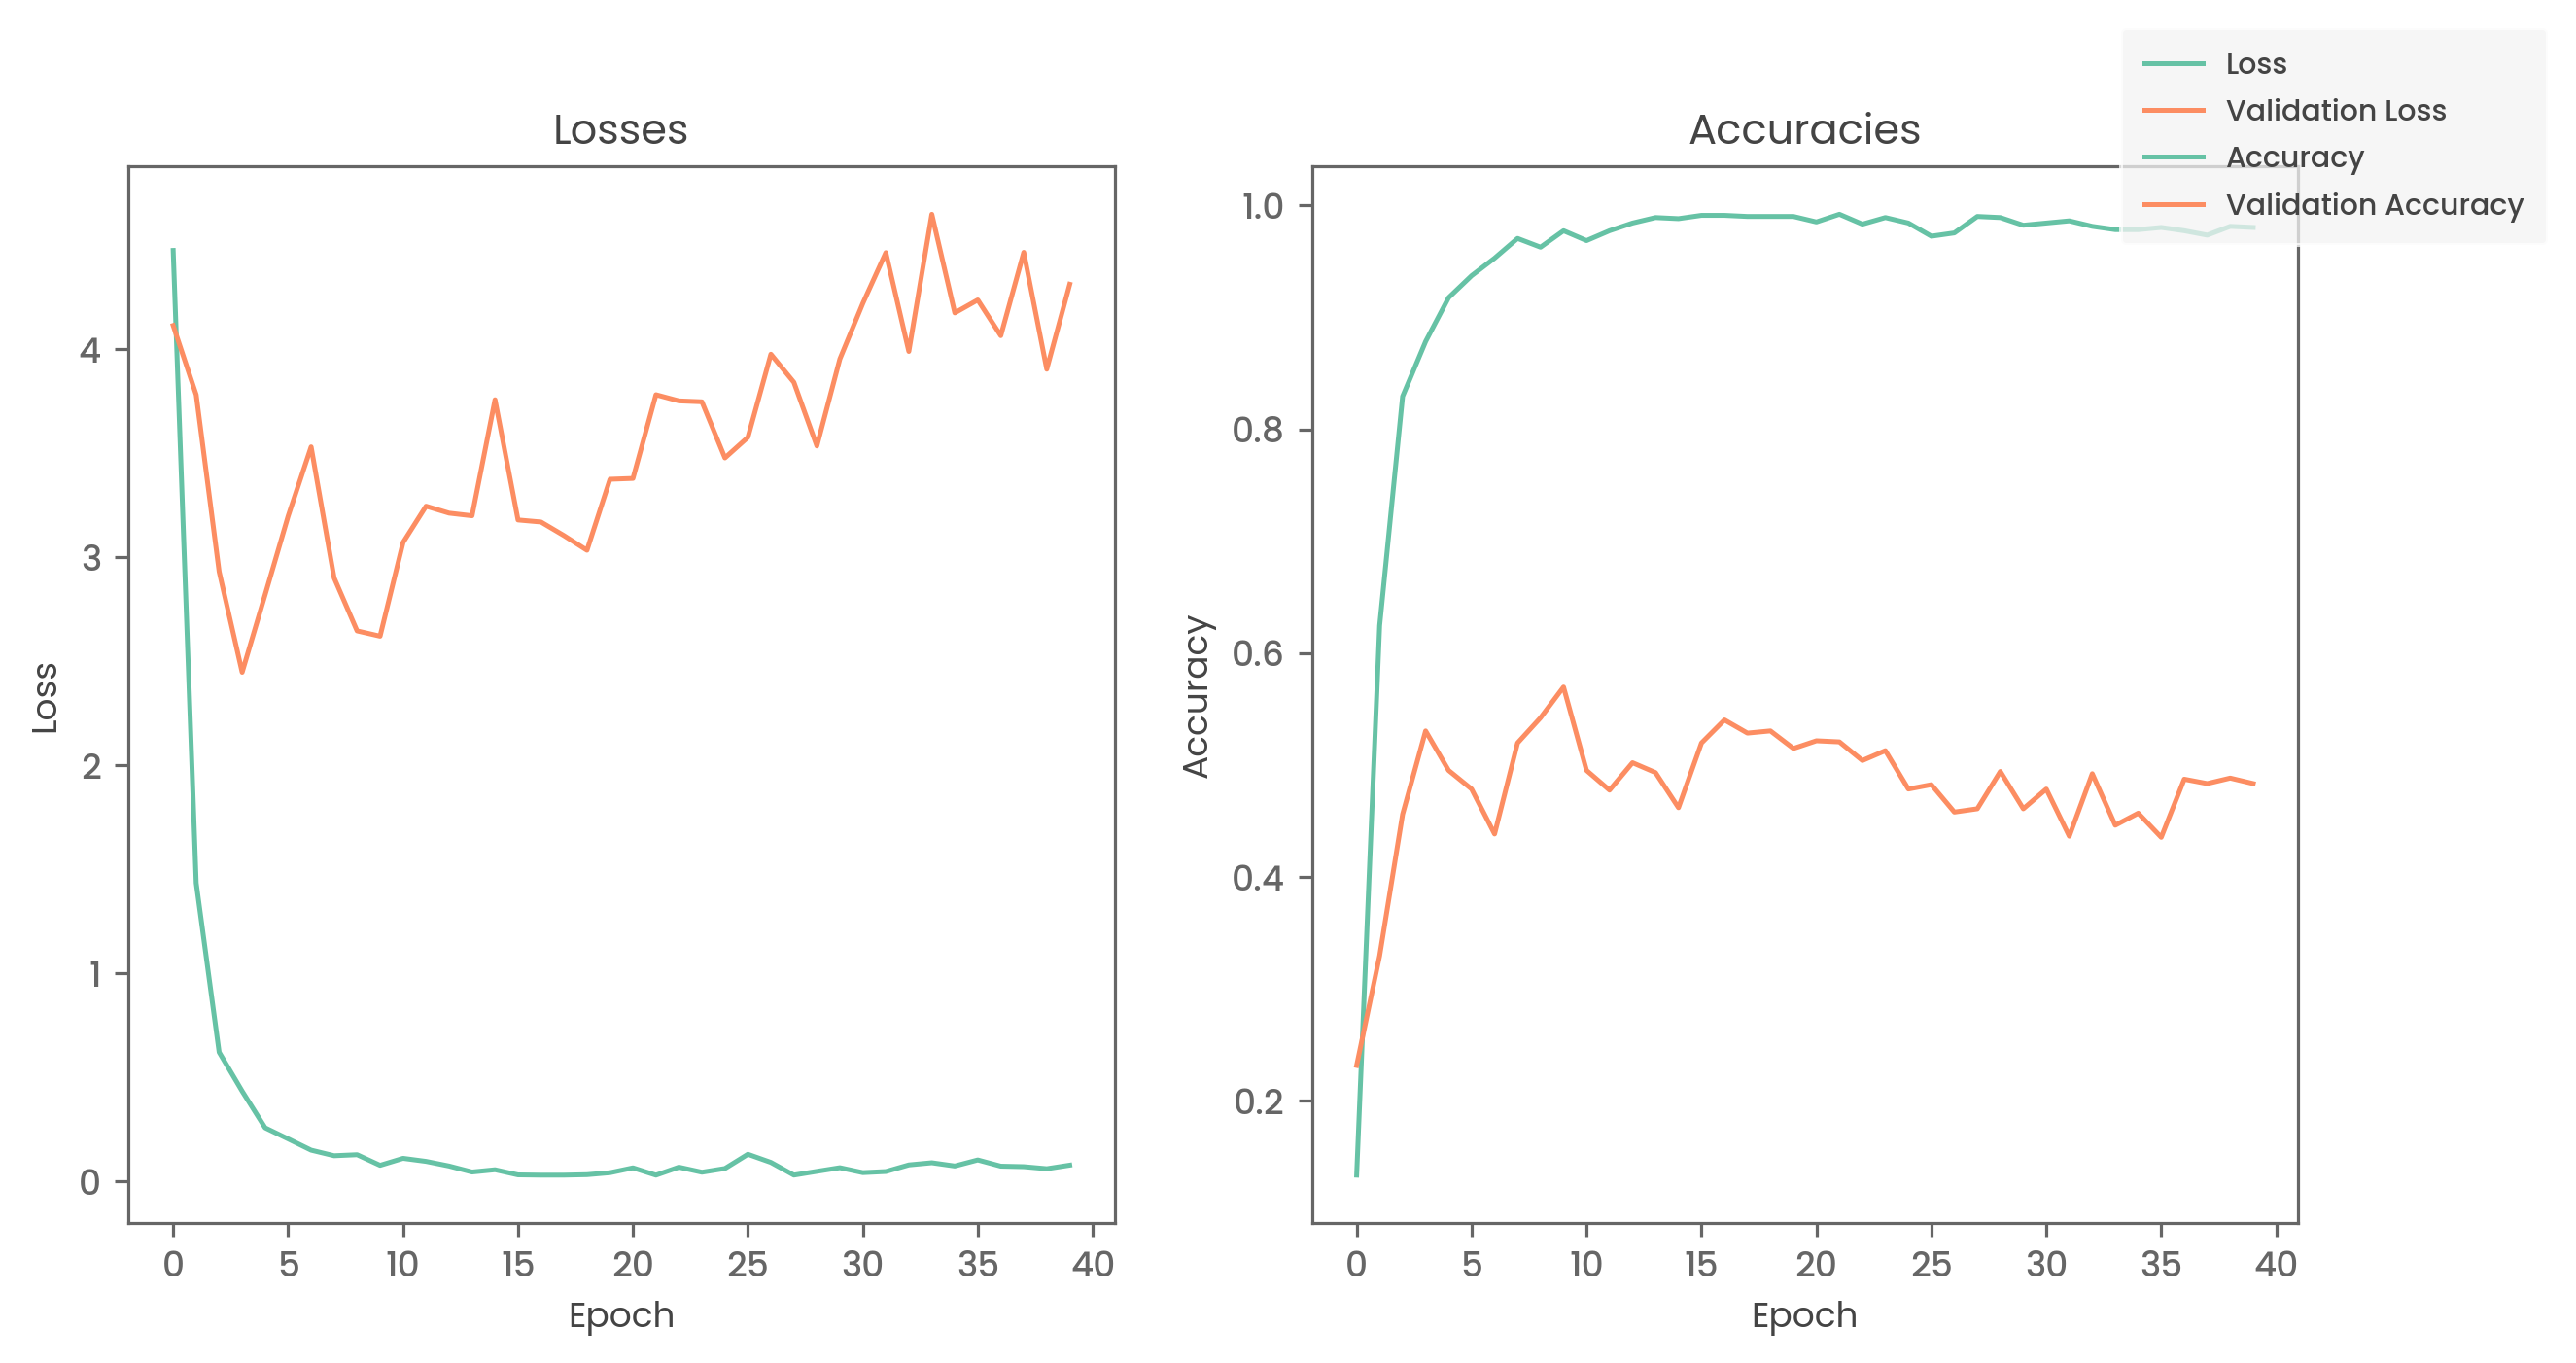

In [11]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

with open('classifier.training.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

plot_history(hist.history)